# Hierarquical clustering of product catalogs using title sizes

The problem we aim to solve here is to cluster product catalogs into higher levels of catalogs. By nature, Vinted already has an hierarchical sequence of natural catalogs. For instance, the primary labels are: Woman, Men, Children, House, Animals, Others

- Woman -> Bras, dresses, leggings, pantyhoses, as well as common clothes (trousers, shirts, shoes, etc)
- Men -> Shoes, shorts, t shirts, shirts, etc
- Children -> same as above
- House -> blankets, towels, pillows, decoration, etc
- Animals -> Toys, grooming, training, etc
- Entertainment -> ...

In addition, this hierarchies have 4 to 5 layers of depth.

- Men -> Shoes -> Sneakers -> Sports sneakers
- Men -> Clothing -> T shirts and tops -> T shirts -> Simple T shirts

## Product catalogs and title sizes

After skimming through the data, I realized the best segmentation feature here is the title sizes. Each category is often linked to a specific size title. Sometimes its very obvious (shoes vs clothing), specially in higher level segmentation; sometimes it can be trickier (women shoes vs men shoes).

As an example:
- M, XL, S, etc which are the standard clothing sizes 
    - But sizes differ between men and women
- no_size for the products which do not have size labels
    - Impossible to distinguish no_size title based on sizing alone
- numeric sizes (40, 41) which refers to footwear
- kids sizes (8 anos, 12 anos, etc)
- cup sizes (95D, 80B)
- jewelry (which im assuming 30 mm diameter refers to)
- volume units (40 x 45 cm)
- weight units (9-18kgs)
- jeans sizes (waist measurements W33)
    - But sizes differ between men and women



In [2]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT brand_title, price_numeric, catalog_id, size_title
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               """
data = pd.read_sql(sql_query, engine)
data

,brand_title,price_numeric,catalog_id,size_title
0,Amazon,9.0,2007.0,
1,Aliexpress,15.0,2662.0,47
2,NoName,60.0,1782.0,L / 40 / 12
3,NoName,60.0,1782.0,M / 38 / 10
4,sansnom.,60.0,1782.0,M / 38 / 10
...,...,...,...,...
727947,findci,12.0,1204.0,S
727948,Zalando,28.0,1056.0,XL / 42 / 14
727949,Amazon,10.0,1779.0,L / 40 / 12
727950,Shein,13.0,1825.0,XL


### Dataset

The dataset used is the Vinted dataset. For this purpose, we are selecting only these variables.

| Variable           | Description       | Range/Unit            |
|--------------------|-------------------|-----------------------|
| brand_title        | Brand           | Char       |
| price_numeric      | Base price           | Numeric    |
| catalog_id         | Catalog       | Numeric (category) |
| size_title         | Size        | Char                  |

In [3]:
data.describe()

,price_numeric,catalog_id
count,727928.000000,727928.000000
mean,17.302886,1347.542196
std,46.113082,861.024240
min,1.000000,11.000000
25%,4.000000,529.000000
50%,7.000000,1542.000000
75%,15.000000,1846.000000
max,3500.000000,2970.000000


In [4]:
data.isna().sum()

brand_title      24
price_numeric    24
catalog_id       24
size_title       24
dtype: int64

In [5]:
data[["brand_title", "size_title"]].nunique()

brand_title    9351
size_title      304
dtype: int64

### Data preparation

Before we start, we need to clean and reshape the data to a preferred format. For this purpose we are using only the sizes as clustering dimensions, because we understand different sizing plays a huge role in product catalogs and reflects other latent variables such as gender, age and type.


The most reasonable metric here is count of each product per size title since price is subjective and affected by other factors. If we were to chose median price or volume, it could be more easily affected by exegenous variables.

In [6]:
data.dropna(axis = 0, inplace= True)
data

,brand_title,price_numeric,catalog_id,size_title
0,Amazon,9.0,2007.0,
1,Aliexpress,15.0,2662.0,47
2,NoName,60.0,1782.0,L / 40 / 12
3,NoName,60.0,1782.0,M / 38 / 10
4,sansnom.,60.0,1782.0,M / 38 / 10
...,...,...,...,...
727947,findci,12.0,1204.0,S
727948,Zalando,28.0,1056.0,XL / 42 / 14
727949,Amazon,10.0,1779.0,L / 40 / 12
727950,Shein,13.0,1825.0,XL


In [7]:
# using product count as metric
pivot_size = data.pivot_table(values='price_numeric', columns='size_title', index='catalog_id', aggfunc='count')
pivot_size

size_title,,0-13 kg,"0-3 meses, 30 cm","1-2 anos, 49 cm",1-3 meses / 56 cm,10,10 anos / 140 cm,100 cm,100 x 150 cm,100B,100E,105 cm,11 anos / 146 cm,11-25 kg,110 cm,115 cm,12,12 anos / 152 cm,12 ou mais > 56 cm,12-18 meses / 80 cm,120 cm,120 x 160 cm,125 cm,125 x 150 cm,13 anos / 158 cm,13-15,130 x 170 cm,14 anos / 164 cm,"14,1 mm Ø / 4","14,9 mm Ø / 6,5",15 anos / 170 cm,15 ou inferior,"15,3 mm Ø / 8","15,7 mm Ø / 9,5",15-36 kg,150 cm - 199 cm,150 x 200 cm,16,16 anos / 176 cm,"16,1 mm Ø / 10,5",...,PT 38 | W28,PT 38 | W29,PT 40 | W30,PT 40 | W31,PT 42 | W32,PT 42 | W33,PT 44 | W34,PT 44 | W35,PT 46 | W36,PT 48 | W38,PT 50 | W40,PT 52 | W42,PT 54 | W44,PT 56 | W46,PT 58 | W48,PT 60 | W50,PT 62 | W52,PT 64 | W54,"Prematuro, até 44 cm","Prematuros, 30 cm",Qualquer,"Recém-nascidos, 44 cm",S,S / 36 / 8,S | 35-38,S | 38-42,Solteiro (135-150 cm x 200-220 cm),Tamanho único,XL,XL / 42 / 14,XS,XS / 34 / 6,XS | 36-37,XXL,XXL / 44 / 16,XXS,XXS / 32 / 4,XXXL,XXXL / 46 / 18,XXXS / 30 / 2
catalog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665.0,NaN,NaN,NaN,45.0,NaN,120.0,NaN,449.0,NaN,NaN,75.0,NaN,21.0,NaN,73.0,47.0
14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578.0,NaN,NaN,NaN,7.0,NaN,211.0,NaN,398.0,NaN,NaN,53.0,NaN,6.0,NaN,10.0,NaN
16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,NaN,NaN,NaN,367.0,NaN,324.0,NaN,223.0,NaN,NaN,63.0,NaN,9.0,NaN,5.0,2.0
19.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2967.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [8]:
from sklearn.preprocessing import MinMaxScaler

# for each catalog, we are going to use minmaxscalar to standardize the scale of the data

pivot_combined = pivot_size.fillna(0)
pivot_combined = pivot_combined.T
for col in pivot_combined.columns:
    pivot_combined[col] = MinMaxScaler().fit_transform(X = pivot_combined[[col]]) #/pivot_combined[col].sum()
pivot_combined 

catalog_id,11.0,14.0,16.0,18.0,19.0,20.0,22.0,26.0,83.0,84.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,94.0,96.0,97.0,98.0,99.0,119.0,120.0,123.0,124.0,140.0,141.0,143.0,145.0,152.0,153.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,...,2920.0,2921.0,2922.0,2923.0,2924.0,2925.0,2927.0,2928.0,2929.0,2931.0,2932.0,2933.0,2934.0,2937.0,2938.0,2939.0,2940.0,2941.0,2942.0,2944.0,2945.0,2949.0,2950.0,2951.0,2952.0,2953.0,2954.0,2955.0,2956.0,2958.0,2959.0,2960.0,2961.0,2962.0,2964.0,2965.0,2967.0,2968.0,2969.0,2970.0
size_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000000,0.000000,0.0,0.000000,1.0,0.549689,0.224784,1.0,0.000000,0.0,0.236246,1.0,0.743119,1.0,0.088889,0.0,0.000000,1.0,0.11194,0.587879,1.0,1.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0-13 kg,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"0-3 meses, 30 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1-2 anos, 49 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-3 meses / 56 cm,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XXS,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XXS / 32 / 4,0.031579,0.010381,0.0,0.007826,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.015030,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001821,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XXXL,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.075085,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.373626,0.0,0.0

## Aglomerative Hierarchical Clustering using Ward Linkage

As indicated by the term hierarchical, the method seeks to build clusters based on hierarchy. Generally, there are two types of clustering strategies: **Agglomerative** and **Divisive**. Here, we mainly focus on the agglomerative approach, which can be easily pictured as a ‘bottom-up’ algorithm.

### Ward Linkage Method

There are four methods for combining clusters in agglomerative approach. The one we choose to use is called Ward’s Method. Unlike the others. Instead of measuring the distance directly, it analyzes the variance of clusters. Ward’s is said to be the most suitable method for quantitative variables.
    
$\Delta(A,B) = \sum_{i\in A \bigcup B} ||\overrightarrow{x_i} - \overrightarrow{m}_{A \bigcup B}||^2 - \sum_{i \in A}||\overrightarrow{x_i} - \overrightarrow{m}_A||^2 -\sum_{i \in B}||\overrightarrow{x_i}- \overrightarrow{m}_B||^2 
= \frac{n_An_B}{n_A+n_B} ||\overrightarrow{m}_A- \overrightarrow{m}_B||^2$

where $\overrightarrow{m}_j$ is the center of cluster j, and $n_j$ is the number of points in it. Δ is called the merging cost of combining the clusters A and B. With hierarchical clustering, the sum of squares starts out at zero (because every point is in its own cluster) and then grows as we merge clusters. Ward’s method keeps this growth as small as possible.

The euclidean distance is the straight line distance between two points in Euclidean Space.

$d(p,q) = \sqrt{(q_1 -p_1)^2 + (q_2 - p_2)^2 + \cdots + (q_n -p_n)^2} = \sqrt{\sum_{i=1} (q_i-p_i)^2}$

In [9]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# dist_matrix is long form distance matrix
# notice this is the intracluster SSE
def intracluster_sse(df: pd.DataFrame) -> float:
    avg = df.mean(axis = 1)
    sse = (df.T - avg).pow(2).sum().sum()
    return (sse)

linkage_matrix = linkage(pivot_combined.T, 'ward')
t_values = np.arange(1, 10.1, 0.1)
avg_sse = []
clusters = []
for t in t_values:
    res = fcluster(linkage_matrix, criterion = "distance", t = t)
    df = pd.DataFrame(res, index = pivot_combined.columns).reset_index()
    grouped_data = df.groupby(0)['catalog_id'].apply(list).reset_index()
    sse_list = []
    clusters.append(len(grouped_data))
    for catalog in grouped_data["catalog_id"]:
        sse_list.append(intracluster_sse(pivot_combined[catalog]))
    avg_sse.append(sum(sse_list))

fig = go.Figure()
fig.add_trace(go.Scatter(x=t_values, y=clusters, mode='lines+markers'))
fig.update_xaxes(title_text="Distance between cluster")
fig.update_yaxes(title_text="Number of clusters")
fig.update_layout(title="Elbow Method Chart - Clusters")

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t_values, y=avg_sse, mode='lines+markers'))
fig.update_xaxes(title_text="Distance between cluster")
fig.update_yaxes(title_text="Mean intra cluster SSE")
fig.update_layout(title="Elbow Method Chart - Mean SSE")

[[165.0, 165.0, 175.0, 175.0], [155.0, 155.0, 170.0, 170.0], [145.0, 145.0, 162.5, 162.5], [135.0, 135.0, 153.75, 153.75], [125.0, 125.0, 144.375, 144.375], [115.0, 115.0, 134.6875, 134.6875], [105.0, 105.0, 124.84375, 124.84375], [95.0, 95.0, 114.921875, 114.921875], [85.0, 85.0, 104.9609375, 104.9609375], [75.0, 75.0, 94.98046875, 94.98046875], [65.0, 65.0, 84.990234375, 84.990234375], [55.0, 55.0, 74.9951171875, 74.9951171875], [45.0, 45.0, 64.99755859375, 64.99755859375], [35.0, 35.0, 54.998779296875, 54.998779296875], [2985.0, 2985.0, 2995.0, 2995.0], [2975.0, 2975.0, 2990.0, 2990.0], [2965.0, 2965.0, 2982.5, 2982.5], [2955.0, 2955.0, 2973.75, 2973.75], [2945.0, 2945.0, 2964.375, 2964.375], [2935.0, 2935.0, 2954.6875, 2954.6875], [2925.0, 2925.0, 2944.84375, 2944.84375], [2915.0, 2915.0, 2934.921875, 2934.921875], [2905.0, 2905.0, 2924.9609375, 2924.9609375], [2895.0, 2895.0, 2914.98046875, 2914.98046875], [2885.0, 2885.0, 2904.990234375, 2904.990234375], [2875.0, 2875.0, 2894.995

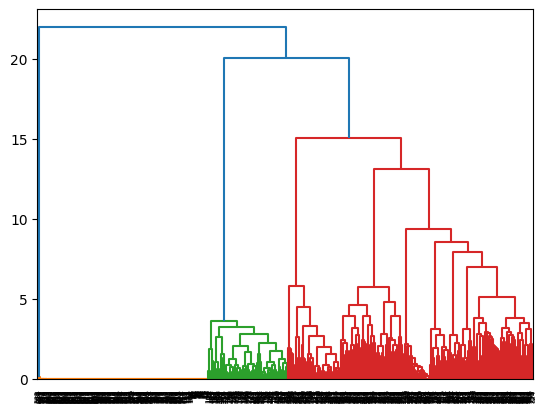

In [39]:
import plotly.figure_factory as ff
import numpy as np


X = dendrogram(linkage_matrix)
print(X["icoord"])
fig = ff.create_dendrogram(np.array(X["icoord"]))
fig.update_layout(width=800, height=500)
fig.show()

In [11]:
t = 2.5

res = fcluster(linkage_matrix, criterion = "distance", t = t)
df = pd.DataFrame(res, index = pivot_combined.columns).reset_index()
print(df)

     catalog_id   0
0          11.0   6
1          14.0   6
2          16.0  30
3          18.0   5
4          19.0   1
..          ...  ..
866      2965.0  27
867      2967.0   1
868      2968.0  33
869      2969.0  38
870      2970.0  37

[871 rows x 2 columns]


### Analysis of Sizing Features

In order to understand how to clustering was done, we are taking a look at each cluster top sizes as well as size dimension.

The result has 25 clusters and the max cluster has 135 labels.

In [12]:
grouped_data = df.groupby(0)['catalog_id'].apply(list).reset_index()
grouped_data['catalog_id_length'] = grouped_data['catalog_id'].apply(lambda x: len(x))
grouped_data

,0,catalog_id,catalog_id_length
0,1,"[19.0, 26.0, 87.0, 89.0, 94.0, 98.0, 99.0, 140...",300
1,2,"[120.0, 124.0, 229.0, 1100.0, 1103.0, 1178.0, ...",9
2,3,"[123.0, 192.0, 193.0, 195.0, 526.0, 1061.0, 10...",13
3,4,"[1067.0, 1126.0, 1129.0, 1263.0, 1773.0, 1780....",7
4,5,"[18.0, 178.0, 179.0, 187.0, 191.0, 194.0, 197....",57
5,6,"[11.0, 14.0, 176.0, 184.0, 185.0, 189.0, 190.0...",53
6,7,"[259.0, 261.0, 263.0, 1787.0, 1816.0, 1817.0, ...",11
7,8,"[1790.0, 1830.0, 2121.0, 2124.0, 2552.0, 2912....",7
8,9,"[1206.0, 1474.0, 1617.0, 1618.0, 1829.0, 1861....",7
9,10,"[92.0, 119.0, 260.0, 1439.0, 1536.0, 1788.0, 1...",10


In [13]:
for catalog in grouped_data["catalog_id"]:
    top_10 = pivot_combined[catalog].sum(axis=1).sort_values(ascending=False).head(10)
    top_10 /= top_10.sum()
    
    # Create a bar chart
    fig = go.Figure([go.Bar(x=top_10.index, y=top_10.values)])
    fig.update_layout(title=f"Top 10 for Catalog {catalog}",
                      xaxis_title="Index",
                      yaxis_title="Sum",
                      )
    fig.show()

In [23]:
pivot_combined.T

size_title,,0-13 kg,"0-3 meses, 30 cm","1-2 anos, 49 cm",1-3 meses / 56 cm,10,10 anos / 140 cm,100 cm,100 x 150 cm,100B,100E,105 cm,11 anos / 146 cm,11-25 kg,110 cm,115 cm,12,12 anos / 152 cm,12 ou mais > 56 cm,12-18 meses / 80 cm,120 cm,120 x 160 cm,125 cm,125 x 150 cm,13 anos / 158 cm,13-15,130 x 170 cm,14 anos / 164 cm,"14,1 mm Ø / 4","14,9 mm Ø / 6,5",15 anos / 170 cm,15 ou inferior,"15,3 mm Ø / 8","15,7 mm Ø / 9,5",15-36 kg,150 cm - 199 cm,150 x 200 cm,16,16 anos / 176 cm,"16,1 mm Ø / 10,5",...,PT 38 | W28,PT 38 | W29,PT 40 | W30,PT 40 | W31,PT 42 | W32,PT 42 | W33,PT 44 | W34,PT 44 | W35,PT 46 | W36,PT 48 | W38,PT 50 | W40,PT 52 | W42,PT 54 | W44,PT 56 | W46,PT 58 | W48,PT 60 | W50,PT 62 | W52,PT 64 | W54,"Prematuro, até 44 cm","Prematuros, 30 cm",Qualquer,"Recém-nascidos, 44 cm",S,S / 36 / 8,S | 35-38,S | 38-42,Solteiro (135-150 cm x 200-220 cm),Tamanho único,XL,XL / 42 / 14,XS,XS / 34 / 6,XS | 36-37,XXL,XXL / 44 / 16,XXS,XXS / 32 / 4,XXXL,XXXL / 46 / 18,XXXS / 30 / 2
catalog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.067669,0.0,0.180451,0.0,0.675188,0.0,0.0,0.112782,0.0,0.031579,0.0,0.109774,0.070677
14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.012111,0.0,0.365052,0.0,0.688581,0.0,0.0,0.091696,0.0,0.010381,0.0,0.017301,0.000000
16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.319130,0.0,0.281739,0.0,0.193913,0.0,0.0,0.054783,0.0,0.007826,0.0,0.004348,0.001739
19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2967.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2968.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [32]:
from sklearn.manifold import TSNE
import plotly.express as px

# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(pivot_combined.T)

pca_df = pd.DataFrame(data=X_tsne, 
                      columns=['PC1', 'PC2'], 
                      index = pivot_combined.T.index)

concat_df = pd.concat([pca_df, 
                       df.set_index("catalog_id")], 
                      ignore_index= False, 
                      axis=1)
concat_df = concat_df.rename(columns={0: 'Cluster'})
concat_df.index = concat_df.index.astype("category")
print(concat_df.index.dtype)

fig = px.scatter(concat_df, x='PC1', y='PC2', color='Cluster', title='t-SNE Plot')

# Update layout and show the plot
#fig.update_layout(title='t-SNE Plot', xaxis_title='Component 1', yaxis_title='Component 2')
fig.show()

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [30]:
# Compute t-SNE embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(pivot_combined.T)

# Create DataFrame for t-SNE results
pca_df = pd.DataFrame(data=X_tsne, columns=['PC1', 'PC2', 'PC3'], index=pivot_combined.T.index)

# Concatenate with original DataFrame
concat_df = pd.concat([pca_df, df.set_index("catalog_id")], ignore_index=False, axis=1)
concat_df = concat_df.rename(columns={0: 'Cluster'})

# Convert index to categorical for proper plotting
concat_df.index = concat_df.index.astype("category")

# Plot 3D t-SNE scatter plot
fig = px.scatter_3d(concat_df, x='PC1', y='PC2', z='PC3', color='Cluster', title='t-SNE 3D Plot')

# Show the plot
fig.show()

### Visualizing the clustering on 2 dimensions using PCA

In [25]:
from sklearn.decomposition import PCA, TruncatedSVD
import pandas as pd

# Assuming df is your DataFrame with the data you want to reduce

# Instantiate PCA with 2 components
pca = TruncatedSVD(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(pivot_combined.T)

# Convert the result to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index = pivot_combined.T.index)
concat_df = pd.concat([pca_df, df.set_index("catalog_id")], ignore_index= False, axis=1)
concat_df = concat_df.rename(columns={0: 'Cluster'})
concat_df


,PC1,PC2,Cluster
catalog_id,,,
11.0,0.010228,1.540501,6
14.0,0.009162,1.578035,6
16.0,0.000029,0.000251,30
18.0,0.013506,1.480955,5
19.0,0.999806,-0.007616,1
...,...,...,...
2965.0,0.015690,0.108937,27
2967.0,0.999806,-0.007616,1
2968.0,0.000042,0.000202,33


In [26]:
import plotly.express as px

# Get the percentage variance explained by each principal component
explained_var_ratio = pca.explained_variance_ratio_

# Create a scatter plot with Plotly
fig = px.scatter(concat_df, x='PC1', y='PC2', color='Cluster', title='PCA Scatter Plot')

# Add the percentage variance explained to the axis labels
fig.update_layout(
    xaxis_title=f'PC1 ({explained_var_ratio[0]*100:.2f}% Variance Explained)',
    yaxis_title=f'PC2 ({explained_var_ratio[1]*100:.2f}% Variance Explained)'
)